INFO: Run with conda environment sc-mar2021

Quality control of snRNA-seq data, e.g. filtering according to counts, number of genes, % of mitochondrial counts

# 0. Load packages

<a id='load_packages'></a>

In [1]:
import os
import sys
import glob
import re

import anndata
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
#import mygene

#import rpy2.rinterface_lib.callbacks
import logging

#from rpy2.robjects import pandas2ri
#import anndata2ri

In [2]:
# Automatically convert rpy2 outputs to pandas dataframes
#pandas2ri.activate()
#anndata2ri.activate()
#%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(20,12) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.8.2
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.19.1
certifi             2022.12.07
cffi                1.14.5
chardet             4.0.0
colorama            0.4.5
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
google              NA
h5py                3.7.0
highs_wrapper       NA
idna                2.10
igraph              0.9.1
ipykernel           5.3.4
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1
leidenalg           0.8.4
llvmlite            0.35.0
louvain             0.7.0
markupsa

In [3]:
sys.path.insert(0,'..')
import paths_downsampling as paths
p = paths.get_paths()
print(p)

{'basedir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/', 'rawdir_RNA': '/psycl/g/mpsngs/HiSeq_Helmholtz/20210324_Anna_Froehlich_10X_RNAseq/03_downsampled/', 'figdir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/figures/', 'writedir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/scanpy_adata/', 'allendir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/reference_data/allen_human/'}


# 1. Load data

<a id='load_data'></a>

In [4]:
# Find all h5 files with pattern
rna_filelist = glob.glob(p['rawdir_RNA'] + '*/bc_feature_matrix_downsampling_perCell.h5')
#print(rna_filelist)

In [ ]:
# Read all h5 files for 12 samples
adatas = {}

for f in rna_filelist:
    print(f)
    
    # extract sample ID from string
    m = re.search(p['rawdir_RNA']+'(.+?)/bc_feature', f)
    if m:
        sample_id = m.group(1)
        print(sample_id)
        
    m1 = re.search('SU(\d+)',sample_id)
    if m1:
        su_number = m1.group(1)
        
    adatas[sample_id] = sc.read_10x_h5(f)
    
    # add sample information to every cell in .obs
    adatas[sample_id].obs['sample'] = sample_id
    adatas[sample_id].obs['individual'] = su_number
    adatas[sample_id].obs['region'] = sample_id.split('_')[1]
    adatas[sample_id].obs['experiment'] = sample_id.split('_')[2]
    
    adatas[sample_id].var_names_make_unique()
    
#print(adatas)

In [6]:
# restructure from map to list
adatas = [adatas[k] for k in adatas.keys()]
#print(adatas)

In [7]:
# concatenate cells from different samples into one matrix
adata = adatas[0].concatenate(adatas[1:])
del adatas
print(adata.var)

/u/ngerst/anaconda3/envs/sc-mar2021/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


                    gene_ids
MIR1302-2HG  ENSG00000243485
FAM138A      ENSG00000237613
OR4F5        ENSG00000186092
AL627309.1   ENSG00000238009
AL627309.3   ENSG00000239945
...                      ...
AC141272.1   ENSG00000277836
AC023491.2   ENSG00000278633
AC007325.1   ENSG00000276017
AC007325.4   ENSG00000278817
AC007325.2   ENSG00000277196

[36601 rows x 1 columns]


In [8]:
adata

AnnData object with n_obs × n_vars = 972131 × 36601
    obs: 'sample', 'individual', 'region', 'experiment', 'batch'
    var: 'gene_ids'

In [9]:
# add phenotype data to adata.obs
phenotype = pd.read_csv(p['basedir']+'phenotype/phenotype_clean.csv', sep = ',')
adata.obs['individual'] = adata.obs['individual'].astype('int64')

# copy adata.obs to new variable for merge
tmp = adata.obs
adata.obs = tmp.reset_index().merge(phenotype, how = 'left', left_on = 'individual', right_on = 'SU.Number',).set_index('index')
adata.obs
adata.obs['individual'] = adata.obs['individual'].astype('category')
adata.obs['Main.Batch'] = adata.obs['Main.Batch'].astype('category')
adata.obs['6-Batch'] = adata.obs['6-Batch'].astype('category')

In [ ]:
# Statistics of data set
print(adata.obs['region'].value_counts())
print('')
print(adata.obs['sample'].value_counts())

In [11]:
# Mean cells per sample
cells_per_sample = adata.obs['individual'].value_counts()
mean_cells = cells_per_sample.mean()
print('Mean cells per sample: '+str(mean_cells))

Mean cells per sample: 10566.641304347826


<Figure size 1152x432 with 0 Axes>

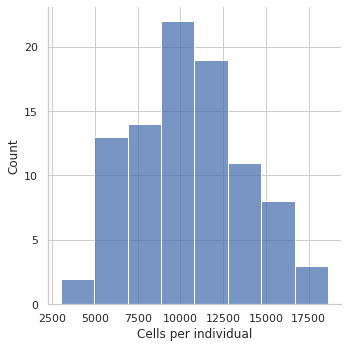

In [12]:
# Histogram of number of cells
mean_cells = pd.Series(cells_per_sample.squeeze()).to_frame()

#plt.rcParams['figure.figsize']=(30,30)
plt.figure(figsize=(16, 6))
#sb.set(rc={'figure.figsize':(10,15)})
sb.set_theme(style="whitegrid")
cell_plot = sb.displot(mean_cells, x="individual")
cell_plot.set(xlabel='Cells per individual')
#cell_plot.savefig(p['figdir']+'hist_cells_downsampling.png')

In [13]:
print(adata.shape)

(972131, 36601)


# 2. Quality Control

<a id='QC'></a>

In [ ]:
# Quality control - calculate QC values
adata.var['mito'] = [symb.startswith('MT-') for symb in adata.var.index]
sc.pp.calculate_qc_metrics(adata, qc_vars=(['mito']), inplace=True)
print(adata.obs)
print(adata.var)

In [ ]:
# Order of samples accroding to 6-Batch
o = adata.obs[['individual', '6-Batch']].drop_duplicates().sort_values(by='6-Batch')
print(o)

In [16]:
# median number of genes
median_genes = np.median(adata.obs['n_genes_by_counts'])
print(median_genes)

# median number of UMI counts
median_counts = np.median(adata.obs['total_counts'])
print(median_counts)

2078.0
3529.0


## 2.1 Violin plots for quality control

### 2.1.1 Total UMI counts per cell

In [ ]:
# Total counts coloured with 6-Batch
plt.rcParams['figure.figsize']=(18,10)
sb.set_theme(style="whitegrid")
ax = sb.violinplot(x='individual', y='total_counts', hue='6-Batch',
                    data=adata.obs, dodge=False, order=o['individual'], palette = sb.color_palette("Spectral", 16))
ax.set_yscale('log')
l = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

### 2.1.2 Percentage of mitochondrial counts per cell

In [ ]:
# Perc mitochondrial coloured with 6-Batch
plt.rcParams['figure.figsize']=(18,10)
sb.set_theme(style="whitegrid")
ax = sb.violinplot(x='individual', y='pct_counts_mito', hue='6-Batch',
                    data=adata.obs, dodge=False, order=o['individual'], palette = sb.color_palette("Spectral", 16))
l = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

### 2.1.3 Number of genes per cell

In [ ]:
# Number of genes coloured with 6-Batch
plt.rcParams['figure.figsize']=(18,10)
sb.set_theme(style="whitegrid")
ax = sb.violinplot(x='individual', y='n_genes_by_counts', hue='6-Batch',
                    data=adata.obs, dodge=False, order=o['individual'], palette = sb.color_palette("Spectral", 16))
l = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

## 2.2 Scatter plots and histograms

### 2.2.1 Scatter plot number of cells vs. number of counts per sample

In [ ]:
# Scatterplot number of cells vs. number of counts per samples
counts = adata.obs.groupby('individual')['total_counts'].sum().to_frame()
counts['individual'] = counts.index.astype('int64').astype('category')
counts.index.name = None

cells = adata.obs['sample'].value_counts().to_frame()
cells.columns = ['n_cells']
cells['sample'] = cells.index
cells['individual'] = cells['sample'].str[2:5].astype('int64').astype('category')

# merge number of counts and number of cells into one df
result = pd.merge(counts, cells, on='individual')
print(result)

# add 6-Batch for colouring of plot
batch6 = adata.obs[['individual', '6-Batch']].drop_duplicates()
#batch6['individual'] = batch6['individual'].astype('int64').astype('category')
result_batch = pd.merge(result, batch6, on='individual')
print(result_batch)
print(result_batch.dtypes)

<AxesSubplot:xlabel='n_cells', ylabel='total_counts'>

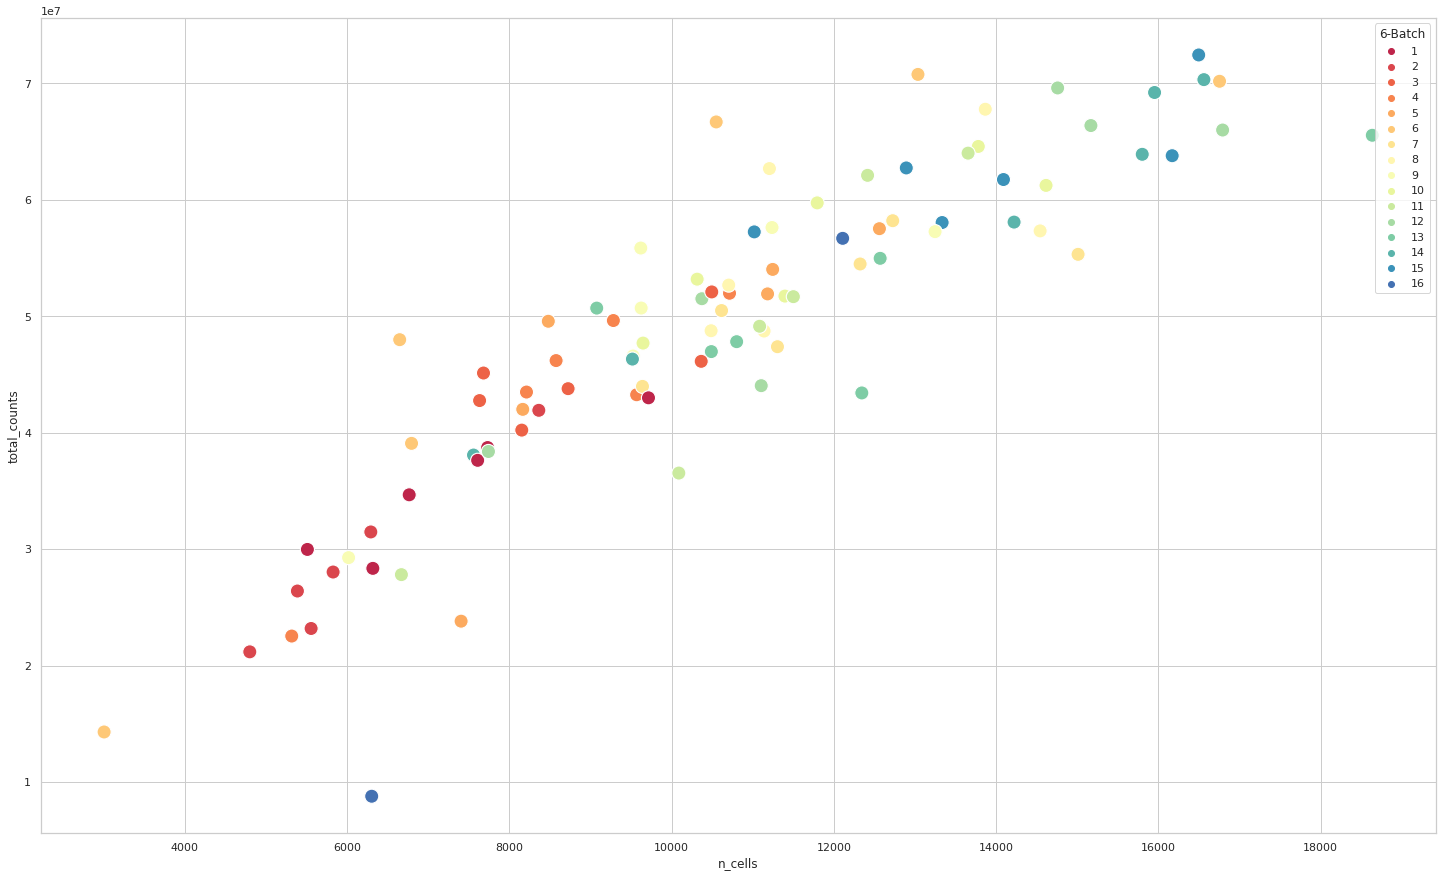

In [21]:
# Actual scatterplot
plt.rcParams['figure.figsize']=(25,15)
sb.scatterplot(data=result_batch, x='n_cells', y='total_counts', hue='6-Batch', palette = sb.color_palette("Spectral", 16), s = 200)

### 2.2.2 Scatter plot total counts vs. number of genes per cell

... storing 'sample' as categorical
... storing 'region' as categorical
... storing 'experiment' as categorical
... storing 'AgeBin' as categorical
... storing 'Sex' as categorical
... storing 'Ethnic.origin' as categorical
... storing 'Classification' as categorical
... storing 'Classification.detail' as categorical
... storing 'Trauma.notes.medical.history' as categorical
... storing 'Hemisphere' as categorical
... storing 'Chlorpromazine.equivalent' as categorical
... storing 'Antidepressants' as categorical
... storing 'Mode.of.death' as categorical
... storing 'Manner.of.Death' as categorical
... storing 'COD.category' as categorical
... storing 'positive.Toxicology' as categorical
... storing 'Antipsychotics' as categorical
... storing 'Antipsychotics.meds.pres' as categorical
... storing 'Smoking.status' as categorical
... storing 'Group' as categorical
... storing 'aaa' as categorical


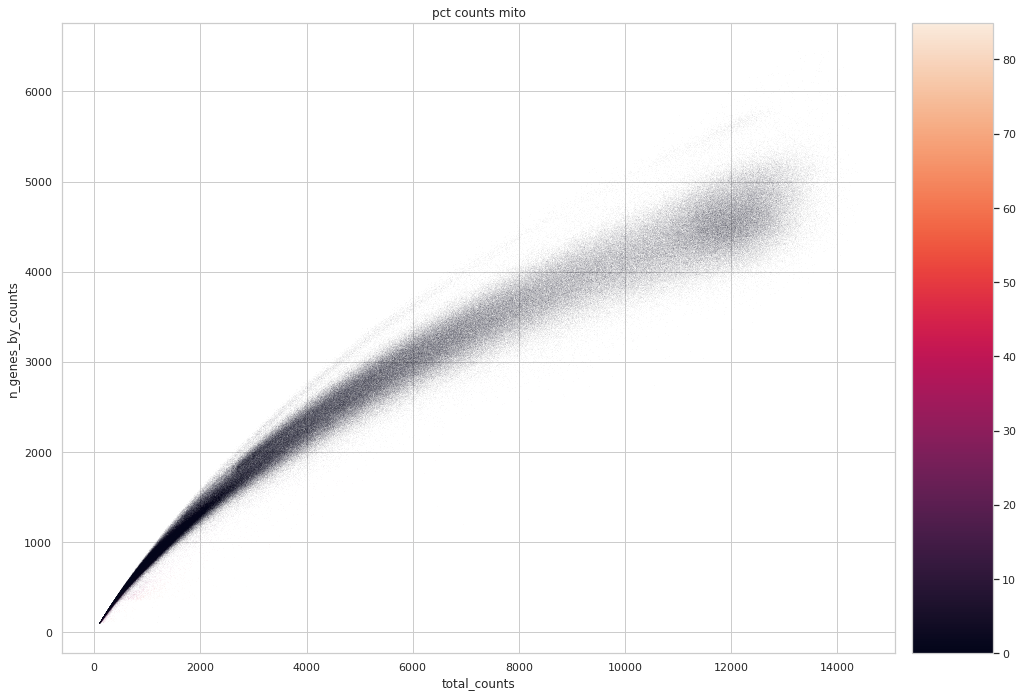

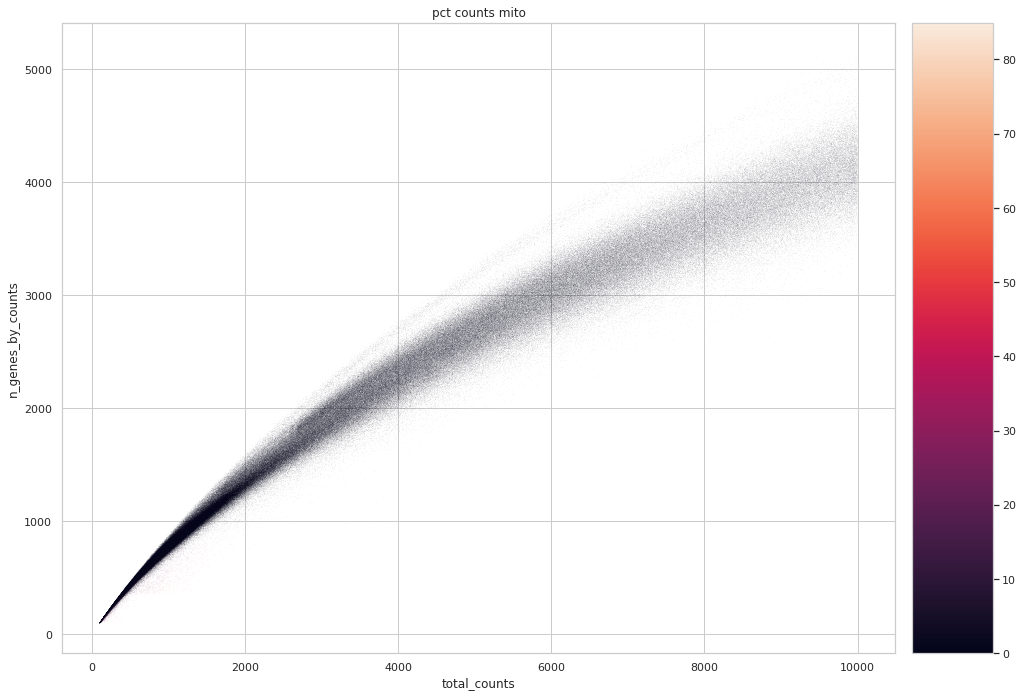

In [22]:
#Data quality summary plots
plt.rcParams['figure.figsize']=(12,12) #rescale figures
p1 = sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_mito')
p2 = sc.pl.scatter(adata[adata.obs['total_counts']<10000], 'total_counts', 'n_genes_by_counts', color='pct_counts_mito')

### 2.2.3 Histogram total counts per cell

/u/ngerst/anaconda3/envs/sc-mar2021/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


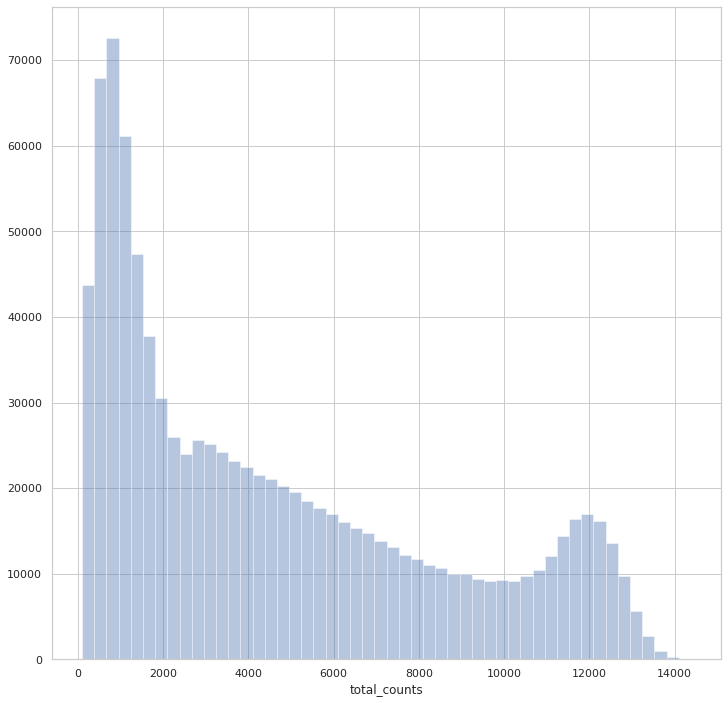

/u/ngerst/anaconda3/envs/sc-mar2021/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


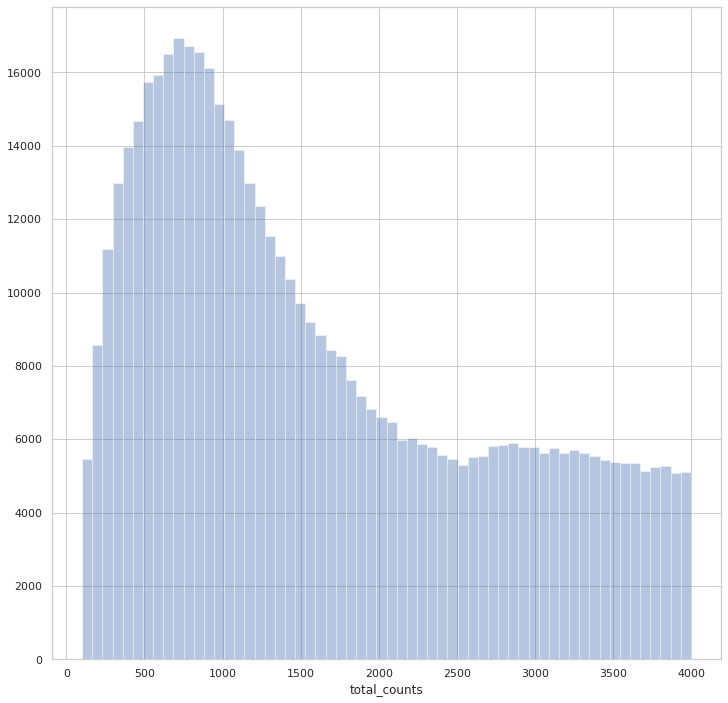

In [23]:
#Thresholding decision: counts per cell
p3 = sb.distplot(adata.obs['total_counts'], kde=False)
plt.show()
#p3.figure.savefig(p['figdir']+'hist_countPerCell_downsampling.png')

p4 = sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']<4000], kde=False, bins=60)
plt.show()
#p3.figure.savefig(p['figdir']+'hist_countPerCell_zoomLeft_downsampling.png')

#p5 = sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']>20000], kde=False, bins=60)
#plt.show()
#p3.figure.savefig(p['figdir']+'hist_countPerCell_zoomRight_downsampling.png')

### 2.2.4 Histogram number of genes per cell

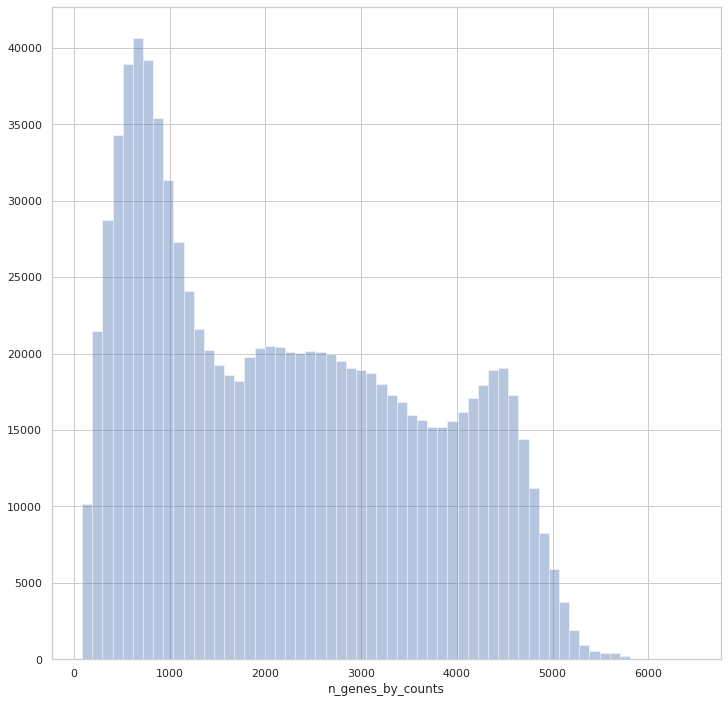

/u/ngerst/anaconda3/envs/sc-mar2021/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


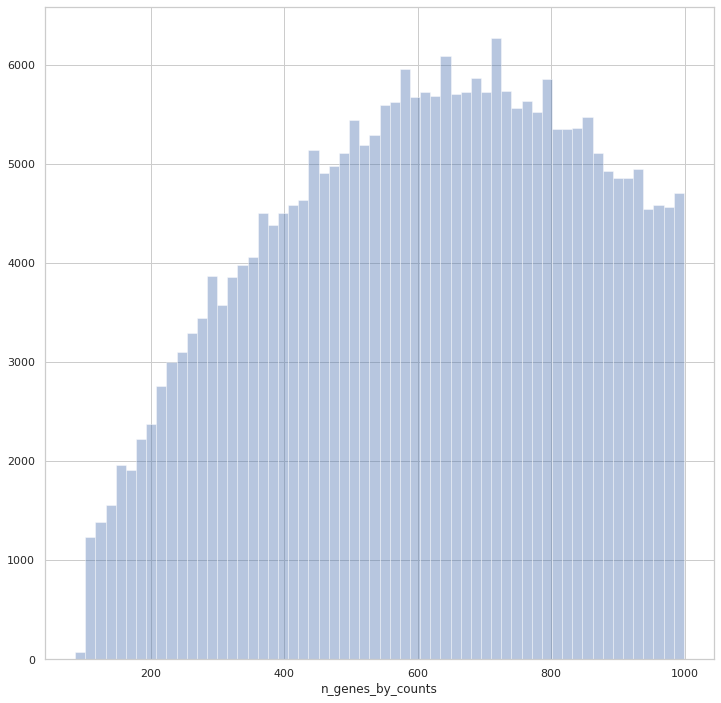

In [24]:
#Thresholding decision: counts per genes
p6 = sb.distplot(adata.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()
#p6.figure.savefig(p['figdir']+'hist_countPerGene_downsampling.png')

p7 = sb.distplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<1000], kde=False, bins=60)
plt.show()
#p7.figure.savefig(p['figdir']+'hist_countPerGene_zoomLeft_downsampling.png')

### 2.2.5 Histogram number of cells a gene is expressed in

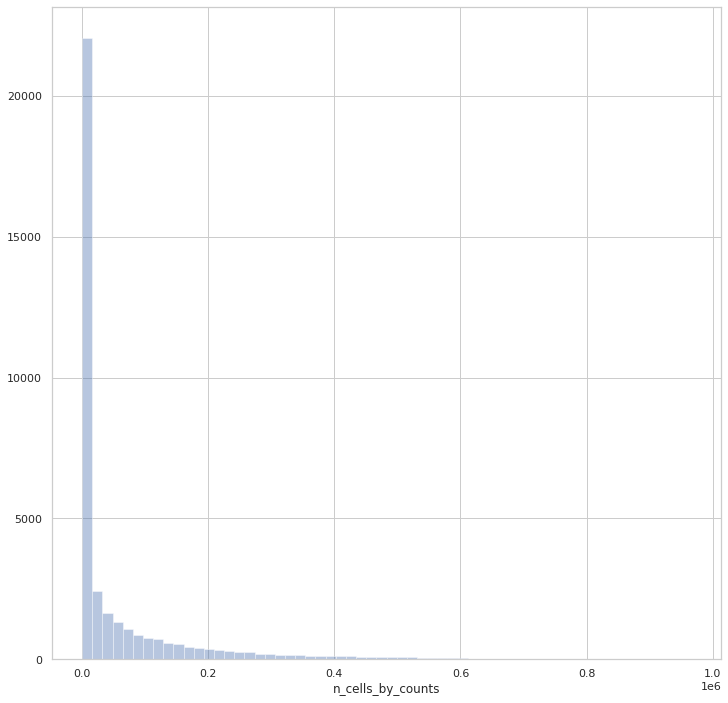

/u/ngerst/anaconda3/envs/sc-mar2021/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


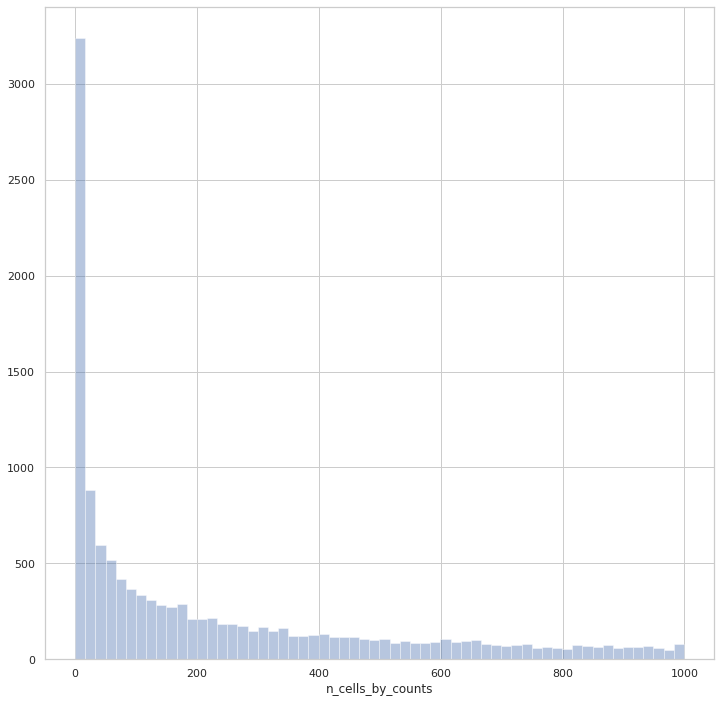

In [25]:
#Thresholding decision: number of cells a gene is expressed in
p8 = sb.distplot(adata.var['n_cells_by_counts'], kde=False, bins=60)
plt.show()
#p8.figure.savefig(p['figdir']+'hist_cellsGeneExp_downsampling.png')

p9 = sb.distplot(adata.var['n_cells_by_counts'][adata.var['n_cells_by_counts']<1000], kde=False, bins=60)
plt.show()
#p9.figure.savefig(p['figdir']+'hist_cellsGeneExp_zoomLeft_downsampling.png')

## 2.3 Explore different thresholds in copied adata object

In [26]:
# Copy adata object to try out cutoffs
adata_qc = adata.copy()

total_cells = adata_qc.n_obs

print('Total number of cells: {:d}'.format(total_cells))

Total number of cells: 972131


In [27]:
# Try out different thresholds (lower bound counts)
sc.pp.filter_cells(adata_qc, min_counts = 500)  # less than 500 counts -> filtered out, uninformative
print('Number of cells after min count filter: {:d}'.format(adata_qc.n_obs))
print('Number of cells filtered out: {:d}'.format(total_cells - adata_qc.n_obs))

sc.pp.filter_cells(adata_qc, min_counts = 750)  # less than 750 counts -> filtered out, uninformative
print('Number of cells after min count filter: {:d}'.format(adata_qc.n_obs))
print('Number of cells filtered out: {:d}'.format(total_cells - adata_qc.n_obs))

sc.pp.filter_cells(adata_qc, min_counts = 1000)  # less than 1000 counts -> filtered out, uninformative
print('Number of cells after min count filter: {:d}'.format(adata_qc.n_obs))
print('Number of cells filtered out: {:d}'.format(total_cells - adata_qc.n_obs))

filtered out 68995 cells that have less than 500 counts
Number of cells after min count filter: 903136
Number of cells filtered out: 68995
filtered out 62694 cells that have less than 750 counts
Number of cells after min count filter: 840442
Number of cells filtered out: 131689
filtered out 62295 cells that have less than 1000 counts
Number of cells after min count filter: 778147
Number of cells filtered out: 193984


In [29]:
# Try out different thresholds for mitochondrial counts
adata_qc = adata.copy()

adata_qc = adata_qc[adata_qc.obs['pct_counts_mito'] < 20]  # more than 20% mitochondrial counts -> filtered out
print('Number of cells after MT filter: {:d}'.format(adata_qc.n_obs))
print('Number of cells filtered out: {:d}'.format(total_cells - adata_qc.n_obs))

adata_qc = adata_qc[adata_qc.obs['pct_counts_mito'] < 15]  # more than 15% mitochondrial counts -> filtered out
print('Number of cells after MT filter: {:d}'.format(adata_qc.n_obs))
print('Number of cells filtered out: {:d}'.format(total_cells - adata_qc.n_obs))

adata_qc = adata_qc[adata_qc.obs['pct_counts_mito'] < 10]  # more than 10% mitochondrial counts -> filtered out
print('Number of cells after MT filter: {:d}'.format(adata_qc.n_obs))
print('Number of cells filtered out: {:d}'.format(total_cells - adata_qc.n_obs))

Number of cells after MT filter: 969633
Number of cells filtered out: 2498
Number of cells after MT filter: 968189
Number of cells filtered out: 3942
Number of cells after MT filter: 964045
Number of cells filtered out: 8086


In [30]:
# Try out minimum number of genes expressed
adata_qc = adata.copy()

sc.pp.filter_cells(adata_qc, min_genes = 100)  # less than 100 genes expressed -> filtered out
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata_qc, min_genes = 300)  # less than 300 genes expressed -> filtered out
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata_qc, min_genes = 500)  # less than 500 genes expressed -> filtered out
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata_qc, min_genes = 750)  # less than 750 genes expressed -> filtered out
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

filtered out 20 cells that have less than 100 genes expressed
Number of cells after gene filter: 972131
filtered out 32169 cells that have less than 300 genes expressed
Number of cells after gene filter: 972131
filtered out 59245 cells that have less than 500 genes expressed
Number of cells after gene filter: 972131
filtered out 93673 cells that have less than 750 genes expressed
Number of cells after gene filter: 972131


In [31]:
#Filter genes:
adata_qc = adata.copy()

total_genes = adata_qc.n_vars
print('Total number of genes: {:d}'.format(total_genes))

# Min 50 cells - filters out 0 count genes
sc.pp.filter_genes(adata_qc, min_cells=50)  # genes detected in less than 50 cells -> filtered out
print('Number of genes after cell filter: {:d}'.format(adata_qc.n_vars))
print('Number of genes filtered out: {:d}'.format(total_genes - adata_qc.n_vars))

# Min 100 cells - filters out 0 count genes
sc.pp.filter_genes(adata_qc, min_cells=100)  # genes detected in less than 100 cells -> filtered out
print('Number of genes after cell filter: {:d}'.format(adata_qc.n_vars))
print('Number of genes filtered out: {:d}'.format(total_genes - adata_qc.n_vars))

# Min 500 cells - filters out 0 count genes
sc.pp.filter_genes(adata_qc, min_cells=500)  # genes detected in less than 500 cells -> filtered out
print('Number of genes after cell filter: {:d}'.format(adata_qc.n_vars))
print('Number of genes filtered out: {:d}'.format(total_genes - adata_qc.n_vars))

# Min 1000 cells - filters out 0 count genes
sc.pp.filter_genes(adata_qc, min_cells=1000)  # genes detected in less than 1000 cells -> filtered out
print('Number of genes after cell filter: {:d}'.format(adata_qc.n_vars))
print('Number of genes filtered out: {:d}'.format(total_genes - adata_qc.n_vars))

Total number of genes: 36601
filtered out 4718 genes that are detected in less than 50 cells
Number of genes after cell filter: 31883
Number of genes filtered out: 4718
filtered out 1303 genes that are detected in less than 100 cells
Number of genes after cell filter: 30580
Number of genes filtered out: 6021
filtered out 4342 genes that are detected in less than 500 cells
Number of genes after cell filter: 26238
Number of genes filtered out: 10363
filtered out 2278 genes that are detected in less than 1000 cells
Number of genes after cell filter: 23960
Number of genes filtered out: 12641


## 2.4 Filter real adata object

In [32]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 500)  # less than 500 counts -> filtered out, uninformative
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

#sc.pp.filter_cells(adata, max_counts = 35000)  # more than 35000 counts -> filtered out
#print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['pct_counts_mito'] < 15]  # more than 15% mitochondrial counts -> filtered out
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 300)  # less than 300 genes expressed -> filtered out
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 972131
filtered out 68995 cells that have less than 500 counts
Number of cells after min count filter: 903136
Number of cells after MT filter: 899908
filtered out 4 cells that have less than 300 genes expressed


/u/ngerst/anaconda3/envs/sc-mar2021/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Number of cells after gene filter: 899904


In [33]:
# Filter genes
# Min 500 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=500)  # genes detected in less than 500 cells -> filtered out
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))  # rerun because the number shown is from adata_qc --> bug was here

filtered out 10406 genes that are detected in less than 500 cells
Number of genes after cell filter: 26195


In [36]:
# Filter out mitochondrial genes
adata[:,adata.var['mito']].var
# only 13 mitochondrial genes left 
adata = adata[:,adata.var['mito'] == False]

In [ ]:
# Number of cells filtered out per sample
cells_per_sample_filt = adata.obs['individual'].value_counts()

df_cells = pd.concat([cells_per_sample.rename('all'), cells_per_sample_filt.rename('filtered')], axis=1)
df_cells['removed'] = df_cells['all'] - df_cells['filtered']
df_cells['perc_removed'] = df_cells['removed'] / df_cells['all']
df_cells['individual'] = df_cells.index

# merge number of cells with 6-batch
df_cells_batch = pd.merge(df_cells, result_batch, on='individual')
df_cells_batch = df_cells_batch.drop_duplicates().sort_values(by='6-Batch')
print(df_cells_batch)

# Plot number of cells left after filtering
#plt.figure()
plt.rcParams['figure.figsize']=(18,10)
plt.figure()
sb.set_theme(style="whitegrid")
ax = sb.barplot(x='individual', y="filtered", data=df_cells_batch, hue='6-Batch',
                    dodge=False, order=df_cells_batch['individual'], palette = sb.color_palette("Spectral", 16))
l = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

# Plot number of cells removed
plt.figure()
plt.rcParams['figure.figsize']=(18,10)
sb.set_theme(style="whitegrid")
ax = sb.barplot(x='individual', y="removed", data=df_cells_batch, hue='6-Batch',
                    dodge=False, order=df_cells_batch['individual'], palette = sb.color_palette("Spectral", 16))
l = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

plt.figure()
plt.rcParams['figure.figsize']=(18,10)
sb.set_theme(style="whitegrid")
ax = sb.barplot(x='individual', y="perc_removed", data=df_cells_batch, hue='6-Batch',
                    dodge=False, order=df_cells_batch['individual'], palette = sb.color_palette("Spectral", 16))
l = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [39]:
# Filter samples --> filter out sample with low RIN and odd data
adata = adata[adata.obs['individual'] != 789]

In [41]:
# Recalculate qc metrics
#del adata.obs['n_counts']
del adata.var['n_cells_by_counts']
sc.pp.calculate_qc_metrics(adata, qc_vars=(['mito']), inplace=True)

/u/ngerst/anaconda3/envs/sc-mar2021/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [ ]:
# Total counts coloured with 6-Batch
plt.rcParams['figure.figsize']=(18,10)
sb.set_theme(style="whitegrid")
ax = sb.violinplot(x='individual', y='total_counts', hue='6-Batch',
                    data=adata.obs, dodge=False, order=o['individual'], palette = sb.color_palette("Spectral", 16))
ax.set_yscale('log')
l = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [ ]:
# Total counts coloured with 6-Batch
plt.rcParams['figure.figsize']=(18,10)
sb.set_theme(style="whitegrid")
ax = sb.violinplot(x='individual', y='n_genes_by_counts', hue='6-Batch',
                    data=adata.obs, dodge=False, order=o['individual'], palette = sb.color_palette("Spectral", 16))
ax.set_yscale('log')
l = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

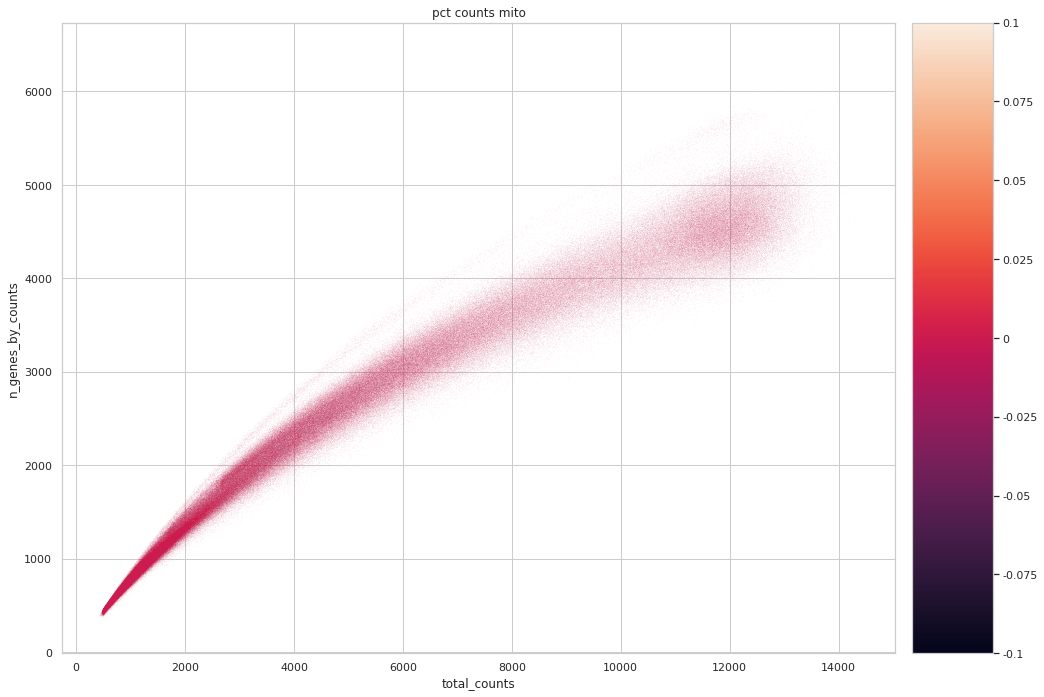

In [44]:
#Data quality summary plots
plt.rcParams['figure.figsize']=(12,12) #rescale figures
p1 = sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_mito')

In [45]:
# Save data to file
adata.write(p['writedir']+'adata_raw_qc_RNA_downsampling_perCell.h5ad')

In [46]:
# Subsample and save for trials of normalization
sc.pp.subsample(adata, fraction = 0.2, random_state = 42)
adata.write(p['writedir']+'adata_raw_qc_RNA_subsample_downsampling_perCell.h5ad')